In [1]:

#libraries
import matplotlib
matplotlib.use('Agg')
#import torch
import numpy as np
from sklearn.metrics import roc_curve, auc, roc_auc_score, cohen_kappa_score, jaccard_similarity_score, log_loss,recall_score, precision_score
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle
import matplotlib.pyplot as plt
from PIL import Image
from utils.eval import *
import os
from itertools import chain

%matplotlib inline

In [68]:

#experiments = '/gpfs/scratch/bilals01/test-repo/experiments/'
#log_file = '/gpfs/scratch/bilals01/test-repo/logs/log_test.log'
experiments = '/scratch/sb3923/PathCNN_data/experiments/train_ds1_vgg16/'
#log_file = '/Users/bilals01/Desktop/PathCNN/logs/log_test_601_1_epoch0.log'
log_file = '/scratch/sb3923/PathCNN_data/logs/train_ds1_vgg16.log'

#exp_name = 'exp_nicolas'
exp_name = 'train_ds1_alexnet'
num_class = 3
#pred_label = 'pred_label_avg_601_0exp_epoch_3.pth.npy'
pred_label = 'test_pred_label_avg_epoch_3.pth.npy'

class_names, class_codes, class_coding = get_class_coding(log_file)
class_coding

class_codes.sort()
class_codes

[0, 1, 2]

In [69]:
#pd.set_option('display.max_rows', 500)

os.chdir(experiments + '/outputs/') #input
pd = np.load(open(pred_label, 'rb'))


In [70]:

os.chdir(experiments +'/outputs/') #input
pd = np.load(open(pred_label, 'rb'))
predictions = pd[:,:num_class] 
labels = pd[:,num_class]

/share/apps/python3/3.5.3/intel/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


AUC:
{0: 0.854346965326093, 1: 0.6324535679374389, 2: 0.6779516072237034, 'macro': 0.72416155176731911, 'recall': 0.45073497874995128, 'micro': 0.61868836742147559, 'precision': 0.3022298666994287, 'cohenskappa': 0.15412093264921733, 'jaccard': 0.40540540540540543, 'logloss': 1.7657948215678938}
CU:
{0: 0.89110105580693821, 1: 0.68534482758620696, 2: 0.73379777265368196, 'macro': 0.87853422619047616, 'micro': 0.64949363425925921}
CL:
{0: 0.81648697214734955, 1: 0.57938664596273293, 2: 0.62596938775510202, 'macro': 0.59534906539763532, 'micro': 0.58663405755886711}


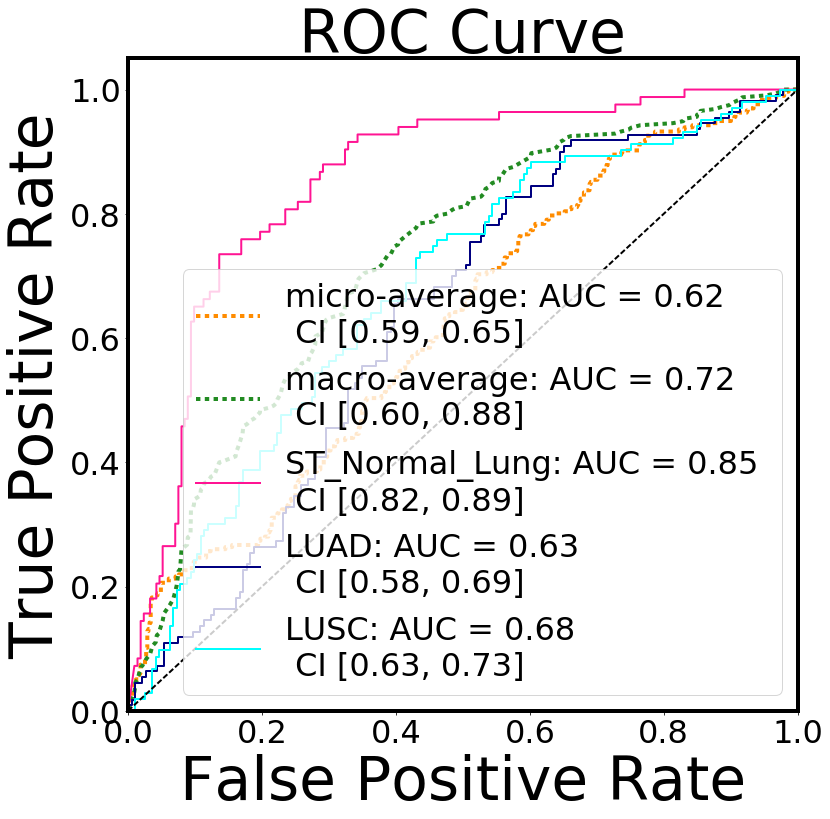

In [71]:
fpr, tpr, roc_auc, cu, cl = get_auc(predictions, labels, class_names, class_codes)

os.chdir(experiments+'/outputs/')
plt.savefig(pred_label[:-8]+'.png', dpi=500, bbox_inches = 'tight')


f = open(pred_label[:-8]+'_results.txt',"w")
f.write( 'TPR\n' )
f.write( "\n".join(map(str,tpr))  + '\n' )
f.write( 'FPR' )
f.write( "\n".join(map(str,fpr))  + '\n' )
f.write( 'roc_auc\n' )
f.write( "\n".join(map(str,roc_auc))  + '\n' )
f.write( 'CU\n' )
f.write( "\n".join(map(str,cu))  + '\n' )
f.write( 'CL\n' )
f.write( "\n".join(map(str,cl))  + '\n' )
f.close()

In [ ]:
#train

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.nn.init as init
from torch.autograd import Variable

import os
import time
import numpy as np
from PIL import Image
from utils.dataloader import *
#use AUC for AUC and CI, auc2 for precision, AUC and CI, auc3 precision auc and CI
from utils.auc import *
from utils import new_transforms
import argparse
import random
import torchvision.models as models

In [ ]:
#if opt.experiment is None:
#    opt.experiment = 'samples'

#os.system('mkdir experiments')
#os.system('mkdir {0}'.format(opt.experiment))
#os.system('mkdir {0}/images'.format(opt.experiment))
#os.system('mkdir {0}/checkpoints'.format(opt.experiment))
#os.system('mkdir {0}/outputs'.format(opt.experiment))
#opt.manualSeed = random.randint(1, 10000) # fix seed
#print("Random Seed: ", opt.manualSeed)
#random.seed(opt.manualSeed)
#torch.manual_seed(opt.manualSeed)

cudnn.benchmark = True

In [ ]:
dropout=0.1
init='leaky' 
model_type='alexnet' 
root_dir='/beegfs/sb3923/DeepCancer/alldata/lung_ds/lung_ds1TilesSorted/' 
num_class=3 
tile_dict_path='/beegfs/sb3923/DeepCancer/alldata/lung_ds/lung_ds1_FileMappingDict.p'
batchSize =32
opt_init='normal'
opt_optimizer= 'Adam'
opt_lr=0.001
imgSize=224

In [ ]:
# Random data augmentation

#imgSize=227
imgSize=224
augment = transforms.Compose([new_transforms.Resize((imgSize, imgSize)),
                              transforms.RandomHorizontalFlip(),
                              new_transforms.RandomRotate(),
                              new_transforms.ColorJitter(0.25, 0.25, 0.25, 0.05),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform = transforms.Compose([new_transforms.Resize((imgSize,imgSize)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

data = {}
loaders = {}

for dset_type in ['valid']:
    if dset_type == 'train' :
        data[dset_type] = TissueData(root_dir, dset_type, transform = augment)
    else:
        data[dset_type] = TissueData(root_dir, dset_type, transform = transform)

    loaders[dset_type] = torch.utils.data.DataLoader(data[dset_type], batch_size=batchSize, shuffle=True)
    print('Finished loading %s dataset: %s samples' % (dset_type, len(data[dset_type])))



In [ ]:
class_to_idx = data['valid'].class_to_idx
classes = data['valid'].classes

print('Class encoding:')
print(class_to_idx)

In [ ]:
#Create model objects
#model = models.alexnet(num_classes=3)
model = models.vgg16(num_classes=3)


#init_model(model)
criterion = nn.CrossEntropyLoss()

print(model)

In [ ]:
#img = torch.load("sample_image.j")
#label = torch.load("sample_label.j")
#input_img = Variable(img)
#target_label = Variable(label)

#train_loss = criterion(model(input_img), target_label)

In [ ]:
#model.forward(input_img)




In [ ]:
for epoch in range(1,20+1):
    data_iter = iter(loaders['valid'])
    i = 0  

    while i < len(loaders['valid']):
        model.train()
        img, label = data_iter.next()
        i += 1
        
        input_img = Variable(img)
        target_label = Variable(label)
        #print('calculating loss:')  
        train_loss = criterion(model(input_img), target_label)
        #print(model(input_img)[0])
        # Zero gradients then backward pass
        #optimizer.zero_grad()
        #train_loss.backward()
        #ptimizer.step()
        
        print(train_loss.data[0])

In [ ]:
torch.save(label, "sample_label.j") 


In [ ]:
# Load checkpoint models if needed

#if opt.cuda:
#    model.cuda()

# Set up optimizer
if opt_optimizer == "Adam":
    optimizer = optim.Adam(model.parameters(), lr=opt_lr, betas=(0.5, 0.999))
elif opt_optimizer == "RMSprop":
    optimizer = optim.RMSprop(model.parameters(), lr = opt_lr)
elif opt_optimizer == "SGD": 
    optimizer = optim.SGD(model.parameters(), lr = opt_lr)
else: 
    raise ValueError('Optimizer not found. Accepted "Adam", "SGD" or "RMSprop"')


In [ ]:
def get_tile_probability(tile_path):

    """
    Returns an array of probabilities for each class given a tile
    @param tile_path: Filepath to the tile
    @return: A ndarray of class probabilities for that tile
    """

    # Some tiles are empty with no path, return nan
    if tile_path == '':
        return np.full(num_classes, np.nan)

    tile_path = root_dir + tile_path

    with open(tile_path, 'rb') as f:
        with Image.open(f) as img:
            img = img.convert('RGB')

    # Model expects a 4D tensor, unsqueeze first dimension
    img = transform(img).unsqueeze(0)



    # Turn output into probabilities with softmax
    var_img = Variable(img, volatile=True)
    output = F.softmax(model(var_img)).data.squeeze(0)

    return output.cpu().numpy()

# Load tile dictionary

with open(tile_dict_path, 'rb') as f:
    tile_dict = pickle.load(f)

def aggregate(file_list, method):

    """
    Given a list of files, return scores for each class according to the
    method and labels for those files.
    @param file_list: A list of file paths to do predictions on
    @param method: 'average' - returns the average probability score across
                               all tiles for that file
                   'max' - predicts each tile to be the class of the maximum
                           score, and returns the proportion of tiles for
                           each class
    @return: a ndarray of class probabilities for all files in the list
             a ndarray of the labels
    """

    model.eval()
    predictions = []
    true_labels = []

    for file in file_list:
        tile_paths, label = tile_dict[file]

        folder = classes[label]

        def add_folder(tile_path):
            if tile_path == '':
                return ''
            else:
                return folder + '/' + tile_path

        # Add the folder for the class name in front
        add_folder_v = np.vectorize(add_folder)
        tile_paths = add_folder_v(tile_paths)

        # Get the probability array for the file
        prob_v = np.vectorize(get_tile_probability, otypes=[np.ndarray])
        probabilities = prob_v(tile_paths)


        """
        imgSize = probabilities.shape()
        newShape = (imgSize[0], imgSize[1], 3)
        probabilities = np.reshape(np.stack(probabilities.flat), newShape)
        """

        if method == 'average':
            probabilities = np.stack(probabilities.flat)
            prediction = np.nanmean(probabilities, axis = 0)

        elif method == 'max':
            probabilities = np.stack(probabilities.flat)
            probabilities = probabilities[~np.isnan(probabilities).all(axis=1)]
            votes = np.nanargmax(probabilities, axis=1)
            
            out = np.array([sum(votes == i) for i in range(num_classes)])
            prediction = out / out.sum()

        else:
            raise ValueError('Method not valid')

        predictions.append(prediction)
        true_labels.append(label)

    return np.array(predictions), np.array(true_labels)

###############################################################################

def early_stop(val_history, t=3, required_progress=0.0001):

    """
    Stop the training if there is no non-trivial progress in k steps
    @param val_history: a list contains all the historical validation auc
    @param required_progress: the next auc should be higher than the previous by 
        at least required_progress amount to be non-trivial
    @param t: number of training steps 
    @return: a boolean indicates if the model should early stop
    """
    
    if (len(val_history) > t+1):
        differences = []
        for x in range(1, t+1):
            differences.append(val_history[-x]-val_history[-(x+1)])
        differences = [y < required_progress for y in differences]
        if sum(differences) == t: 
            return True
        else:
            return False
    else:
        return False


stop_training = False

###############################################################################

def adjust_learning_rate(optimizer, epoch):

    """Sets the learning rate to the initial LR decayed by 10 every 3 epochs
        Function copied from: https://github.com/pytorch/examples/blob/master/imagenet/main.py"""
    
    lr = opt.lr * (0.1 ** (epoch // 3)) # Original
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr




In [ ]:
###############################################################################

"""
Training loop
"""

best_AUC = 0.0

print('Starting training')
start = time.time()
#correc=0
#total=0

print(time.time())
for epoch in range(1,20+1):
    data_iter = iter(loaders['train'])
    i = 0
    

    while i < len(loaders['train']):
        model.train()
        img, label = data_iter.next()
        i += 1

        # Drop the last batch if it's not the same size as the batchsize
        if img.size(0) != 32:
            break



        input_img = Variable(img)
        target_label = Variable(label)

        train_loss = criterion(model(input_img), target_label)
        #print(model(input_img)[0])
        # Zero gradients then backward pass
        optimizer.zero_grad()
        train_loss.backward()

        optimizer.step()
        
        print('[%d/%d][%d/%d] Training Loss: %f'
               % (epoch, opt.niter, i, len(loaders['train']), train_loss.data[0]))
        ii=i+((epoch)*len(loaders['train']))
        #get validation AUC every step_freq 
        if ii % step_freq == 0:
            val_predictions, val_labels = aggregate(data['valid'].filenames, method=opt.method)

            data_ = np.column_stack((np.asarray(val_predictions),np.asarray(val_labels)))
            data_.dump(open('{0}/outputs/val_pred_label_avg_{0}_step_{1}.npy'.format(opt.experiment,str(ii)), 'wb'))
            torch.save(model.state_dict(), '{0}/checkpoints/step_{1}.pth'.format(opt.experiment, str(ii)))           
            print('validation scores:')

            roc_auc = get_auc('{0}/images/val_roc_step_{1}.jpg'.format(opt.experiment,epoch), val_predictions, val_labels, classes = range(num_classes))
            for k, v in roc_auc.items(): 
                if k in range(num_classes):
                    k = classes[k] 
                #experiment.log_metric("{0} AUC".format(k), v)
                print('%s AUC: %0.4f' % (k, v))

    #save the checkpoint at every epoch
    torch.save(model.state_dict(), '{0}/checkpoints/epoch_{1}.pth'.format(opt.experiment, str(epoch)))

    #print(time.time())
    # Get validation AUC once per epoch
    if opt.calc_val_auc:
        val_predictions, val_labels = aggregate(data['valid'].filenames, method=opt.method)
        data_ = np.column_stack((np.asarray(val_predictions),np.asarray(val_labels)))
        data_.dump(open('{0}/outputs/val_pred_label_avg_epoch_{1}.npy'.format(opt.experiment,str(epoch)), 'wb'))

        roc_auc = get_auc('{0}/images/val_roc_epoch_{1}.jpg'.format(opt.experiment, epoch),
                      val_predictions, val_labels, classes = range(num_classes))

        for k, v in roc_auc.items():
            if k in range(num_classes):
                k = classes[k]

            #experiment.log_metric("{0} AUC".format(k), v)
            print('%s AUC: %0.4f' % (k, v))

    # Stop training if no progress on AUC is being made
    if opt.earlystop:
        validation_history.append(roc_auc['macro'])
        stop_training = early_stop(validation_history)

        if stop_training: 
            print("Early stop triggered")
            break

# Final evaluation
print('Finished training, best AUC: %0.4f' % (best_AUC))
end = time.time()
print(end-start)

In [ ]:
model.forward(input_img)